Áudio 'audio_entrada.wav' carregado. Frequência de amostragem: 44100 Hz.
Áudio estéreo detectado. Convertendo para mono.

--- ANÁLISE DO SINAL DE ENTRADA ---


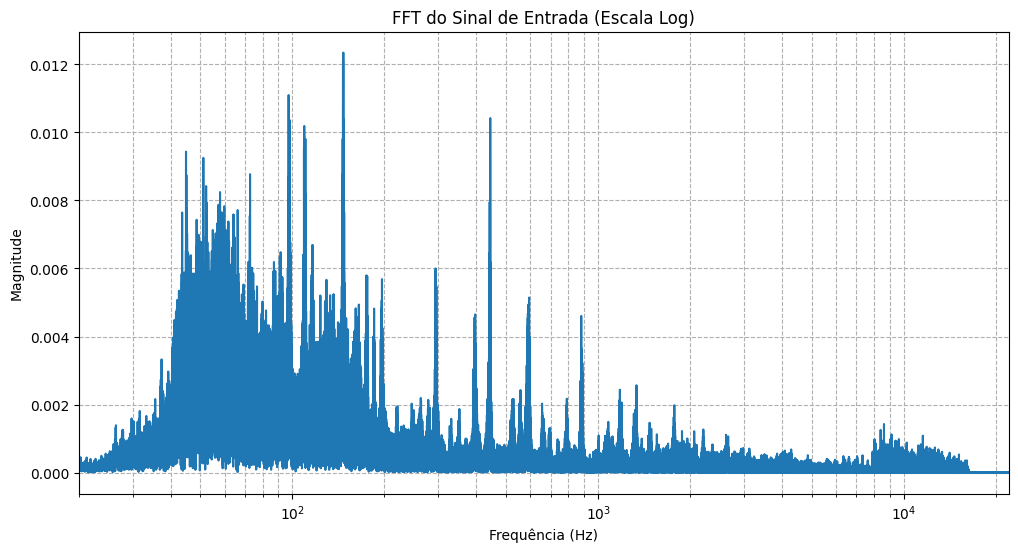


--- CONFIGURAÇÃO DO EQUALIZADOR FIR DE 4 BANDAS ---
Digite a frequência central (Hz) da banda 1: 80
Digite o ganho (dB) para 80.0 Hz (ex: 6 ou -3.5): 1.5
Digite o fator Q para 80.0 Hz (ex: 1.0): 0.7
Digite a frequência central (Hz) da banda 2: 800
Digite o ganho (dB) para 800.0 Hz (ex: 6 ou -3.5): 2
Digite o fator Q para 800.0 Hz (ex: 1.0): 0.5
Digite a frequência central (Hz) da banda 3: 2000
Digite o ganho (dB) para 2000.0 Hz (ex: 6 ou -3.5): -1
Digite o fator Q para 2000.0 Hz (ex: 1.0): 0.8
Digite a frequência central (Hz) da banda 4: 8000
Digite o ganho (dB) para 8000.0 Hz (ex: 6 ou -3.5): 1
Digite o fator Q para 8000.0 Hz (ex: 1.0): 0.5

Projetando e combinando os filtros...

--- ANÁLISE DO FILTRO EQUALIZADOR COMBINADO ---


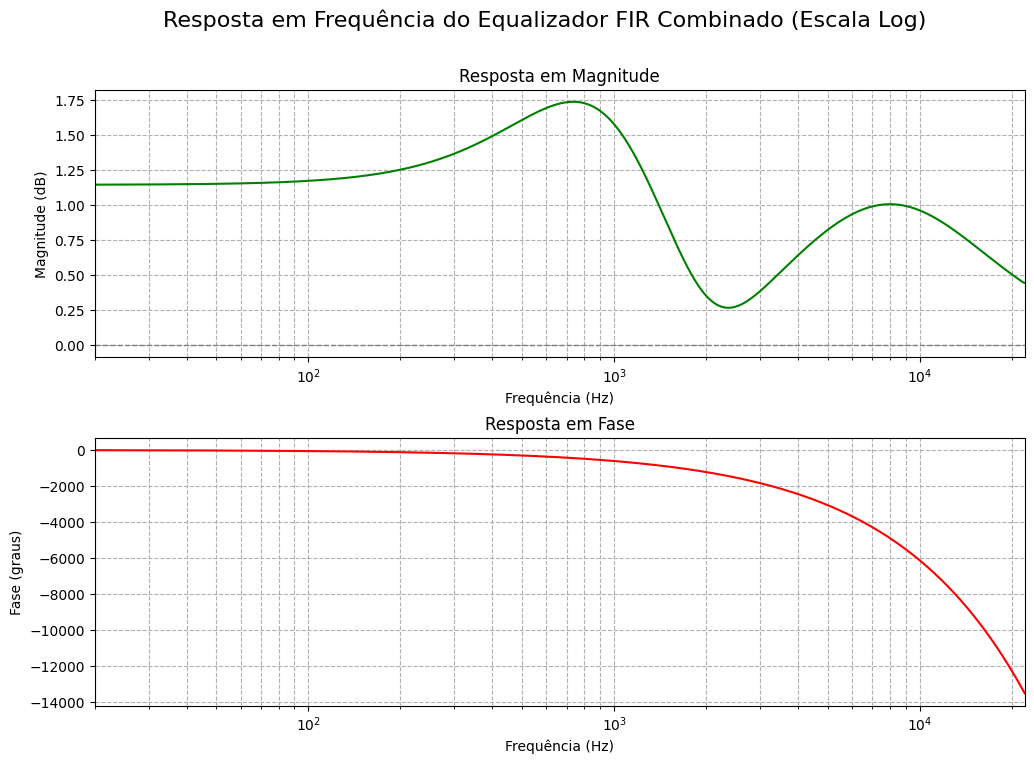


--- APLICANDO O FILTRO AO SINAL DE ÁUDIO (MÉTODO RÁPIDO) ---
Realizando a convolução via FFT...
Convolução concluída.
Áudio salvo em 'audio_saida_equalizado_fir.wav'.

--- ANÁLISE DO SINAL DE SAÍDA ---


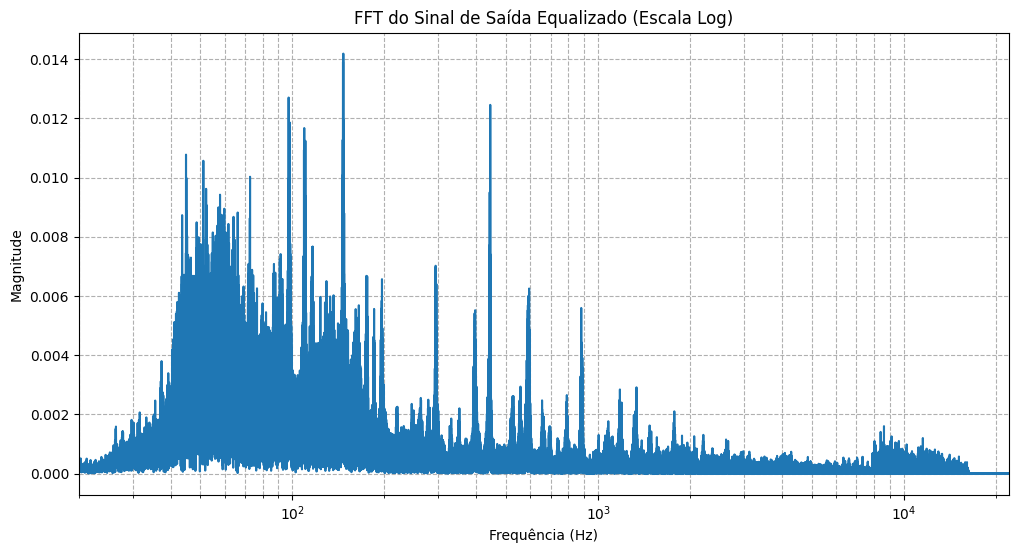

In [3]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import warnings

# --- Funções de Carregamento e Salvamento de Áudio ---

def carregar_audio(filename):
    """Carrega um arquivo de áudio .wav e converte para mono e float."""
    try:
        fs, audio = wavfile.read(filename)
        print(f"Áudio '{filename}' carregado. Frequência de amostragem: {fs} Hz.")
    except FileNotFoundError:
        print(f"Erro: O arquivo '{filename}' não foi encontrado.")
        return None, None
    except Exception as e:
        print(f"Erro ao ler o arquivo de áudio: {e}")
        return None, None

    dtype = audio.dtype
    if dtype == np.int16:
        audio_normalizado = audio / 32768.0
    elif dtype == np.uint8:
        audio_normalizado = (audio / 127.5) - 1.0
    else:
        print(f"Aviso: Tipo de dado não padrão detectado ({dtype}). Tentando normalização.")
        try:
            dtype_info = np.iinfo(dtype)
            audio_normalizado = audio / -dtype_info.min if dtype_info.min != 0 else audio / dtype_info.max
        except ValueError:
            print(f"Erro: Formato de áudio '{dtype}' não suportado.")
            return None, None

    if audio_normalizado.ndim > 1:
        print("Áudio estéreo detectado. Convertendo para mono.")
        audio_normalizado = np.mean(audio_normalizado, axis=1)

    return fs, audio_normalizado

def salvar_audio(filename, fs, audio):
    """Salva o áudio processado em um arquivo .wav."""
    audio_clipped = np.clip(audio, -1.0, 1.0)
    audio_int16 = np.int16(audio_clipped * 32767)
    wavfile.write(filename, fs, audio_int16)
    print(f"Áudio salvo em '{filename}'.")

# --- Funções de Análise e Plotagem (ATUALIZADAS) ---

# --- ATUALIZAÇÃO AQUI ---
def plotar_fft_log(sinal, fs, titulo):
    """Plota a FFT de um sinal com eixo de frequência em escala logarítmica."""
    N = len(sinal)
    if N == 0:
        print("Aviso: Sinal vazio, não é possível calcular a FFT.")
        return

    fft_result = np.fft.fft(sinal)
    fft_freqs = np.fft.fftfreq(N, d=1/fs)
    metade = N // 2
    fft_freqs_positivas = fft_freqs[:metade]
    fft_magnitude = (2.0/N) * np.abs(fft_result[:metade])

    plt.figure(figsize=(12, 6))

    # ATUALIZAÇÃO: Usando plt.plot para melhor visualização em escala log
    plt.plot(fft_freqs_positivas, fft_magnitude)

    # ATUALIZAÇÃO: Definindo a escala do eixo X para logarítmica
    plt.xscale('log')

    plt.title(titulo)
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude')

    # Habilita a grade para as marcações maiores e menores, o que ajuda na escala log
    plt.grid(True, which="both", ls="--")

    # ATUALIZAÇÃO: Escala log não pode começar em 0. Usamos 20 Hz.
    plt.xlim(20, fs/2)
    plt.show()

# --- ATUALIZAÇÃO AQUI ---
def plotar_resp_freq_fir(w, h, fs, titulo):
    """Plota a resposta em frequência (magnitude e fase) com eixo logarítmico."""
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle(titulo, fontsize=16)
    fig.subplots_adjust(hspace=0.3)

    # Gráfico de Magnitude
    axs[0].plot(w, 20 * np.log10(np.abs(h) + 1e-9), 'g')
    axs[0].set_title('Resposta em Magnitude')
    axs[0].set_xlabel('Frequência (Hz)')
    axs[0].set_ylabel('Magnitude (dB)')
    axs[0].grid(True, which="both", ls="--")
    axs[0].axhline(0, color='grey', lw=1, linestyle='--')
    # ATUALIZAÇÃO: Definindo a escala do eixo X para logarítmica
    axs[0].set_xscale('log')
    # ATUALIZAÇÃO: Ajustando o limite inferior para a escala log
    axs[0].set_xlim(20, fs/2)

    # Gráfico de Fase
    phase = np.unwrap(np.angle(h))
    axs[1].plot(w, np.degrees(phase), 'r')
    axs[1].set_title('Resposta em Fase')
    axs[1].set_xlabel('Frequência (Hz)')
    axs[1].set_ylabel('Fase (graus)')
    axs[1].grid(True, which="both", ls="--")
    # ATUALIZAÇÃO: Definindo a escala do eixo X para logarítmica
    axs[1].set_xscale('log')
    # ATUALIZAÇÃO: Ajustando o limite inferior para a escala log
    axs[1].set_xlim(20, fs/2)
    plt.show()

# --- Funções de Projeto e Aplicação do Filtro (sem alterações) ---

def projetar_filtro_peak(f_center, ganho_db, q, fs, num_taps=101):
    if num_taps % 2 == 0:
        num_taps += 1
    f_norm = np.linspace(0, 1, 512)
    ganho_linear = 10**(ganho_db / 20.0)
    f0_norm = f_center / (fs/2)
    bw_norm = f0_norm / q
    termo = ( (f_norm**2 - f0_norm**2) / (f_norm * bw_norm + 1e-9) )**2
    H = np.sqrt( (1 + (ganho_linear**2 - 1) / (1 + termo)) )
    freqs = f_norm
    gains = H
    taps = signal.firwin2(num_taps, freqs, gains)
    return taps

# --- PROGRAMA PRINCIPAL ---

if __name__ == "__main__":
    warnings.filterwarnings("ignore", category=UserWarning)

    # --- 1. Definições ---
    arquivo_entrada = 'audio_entrada.wav'
    arquivo_saida = 'audio_saida_equalizado_fir.wav'
    num_taps_filtro = 151

    # --- 2. Carregar Áudio ---
    fs, audio_original = carregar_audio(arquivo_entrada)

    if audio_original is not None:

        # --- 3. Análise do Sinal de Entrada ---
        print("\n--- ANÁLISE DO SINAL DE ENTRADA ---")
        plotar_fft_log(audio_original, fs, 'FFT do Sinal de Entrada (Escala Log)')

        # --- 4. Coletar Parâmetros dos Filtros ---
        print("\n--- CONFIGURAÇÃO DO EQUALIZADOR FIR DE 4 BANDAS ---")
        filtros_config = []
        for i in range(4):
            while True:
                try:
                    f_center = float(input(f"Digite a frequência central (Hz) da banda {i+1}: "))
                    ganho_db = float(input(f"Digite o ganho (dB) para {f_center} Hz (ex: 6 ou -3.5): "))
                    q_factor = float(input(f"Digite o fator Q para {f_center} Hz (ex: 1.0): "))
                    if f_center <= 20 or f_center >= fs/2:
                        print(f"Erro: A frequência deve estar entre 20 e {fs/2} Hz. Tente novamente.")
                    elif q_factor <= 0:
                        print("Erro: O fator Q deve ser maior que zero. Tente novamente.")
                    else:
                        filtros_config.append({'f_center': f_center, 'ganho_db': ganho_db, 'q': q_factor})
                        break
                except ValueError:
                    print("Entrada inválida. Por favor, insira um número.")

        # --- 5. Projetar e Combinar os Filtros ---
        print("\nProjetando e combinando os filtros...")

        taps_equalizador = np.zeros(num_taps_filtro)
        centro = num_taps_filtro // 2
        taps_equalizador[centro] = 1.0

        for config in filtros_config:
            taps_individuais = projetar_filtro_peak(config['f_center'], config['ganho_db'], config['q'], fs, num_taps_filtro)
            taps_equalizador = np.convolve(taps_equalizador, taps_individuais, mode='same')

        # --- 6. Análise do Filtro Combinado ---
        print("\n--- ANÁLISE DO FILTRO EQUALIZADOR COMBINADO ---")
        w, h = signal.freqz(taps_equalizador, worN=8000, fs=fs)
        plotar_resp_freq_fir(w, h, fs, 'Resposta em Frequência do Equalizador FIR Combinado (Escala Log)')

        # --- 7. Aplicar o Equalizador ao Áudio ---
        print("\n--- APLICANDO O FILTRO AO SINAL DE ÁUDIO (MÉTODO RÁPIDO) ---")
        print("Realizando a convolução via FFT...")

        audio_final = signal.fftconvolve(audio_original, taps_equalizador, mode='same')

        print("Convolução concluída.")

        # --- 8. Salvar e Analisar o Sinal de Saída ---
        salvar_audio(arquivo_saida, fs, audio_final)

        print("\n--- ANÁLISE DO SINAL DE SAÍDA ---")
        plotar_fft_log(audio_final, fs, 'FFT do Sinal de Saída Equalizado (Escala Log)')